<a href="https://colab.research.google.com/github/choety0/Deep-Learning-Based-ECG-Annotator/blob/master/LSTM_2d_sel100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   2개의 센서 값 (properties = 2)을 학습에 사용한다.
*   또한 expSize 만큼을 예측 크기로 정한다.
*   예측 범위의 중간을 예측 포인트로 정한다. (이전 실험에서는 [i:i+ts]를 입력으로 [i+ts: i+ts+expSize] 만큼의 예측 출력을 얻으면 이를 체크해서 i번째에 anomaly 발생여부를 기입했는데, 이제는 i+ts+expSize/2의 위치에 anomaly 발생 여부를 기입한다. 이를 위해 i의 시작 위치를 0에서 ts로 바꾼다.
*   보통 LSTM 신경망의 끝은 dense layer인데, 1차원의 배열만 출력될 수 있다. expSize * properties의 예측값을 학습에 사용하기 위해서는 2d 예측값 [[d^1_i, d^2_i], [d^1_{i+1}, d^2_{i+1}], ..., [d^1_{i+p}, d^2_{i+p}]]를 1d 예측값 [d^1_i, d^1_{i+1}, ..., d^1_{i+p}, d^2_i, d^2_{i+1}, ..., d^2_{i+p}]로 바꾼다. 이는 training set과 test set에 모두 적용된다. 즉, Y의 size가 2배가 된다. 또한 마지막 dense layer의 크기도 2배가 된다.


# 새 섹션

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout, Flatten
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# 두 배열에 1.0보다 큰 값이 있으면 True 반환, 아니면 False 반환
def abnormal(arr1, arr2):
    for val in arr1:
        if val > 1.0:
            return True
    for val in arr2:
        if val > 1.0:
            return True
    return False

In [3]:
test_prop = 0.2
train_prop = 1 - test_prop
ts = 220  # time-step size
expSize = 7  # expectation size
cycle = 220
L1size = 64
L2size = 32
DOrate = 0.2

In [4]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/sel100/merged.csv")
print(data.shape)

(225000, 5)


In [5]:
cols = list(data)[1:3]
print(cols)
data_for_training = data[cols].astype(float)
scaler = StandardScaler()
scaler = scaler.fit(data_for_training)
data_for_training_scaled = scaler.transform(data_for_training)
train_size = int(len(data) * train_prop)-ts-expSize
print("train size:", train_size, ", data_for_training shape:", data_for_training.shape)
X = []
Y = []
for i in range(ts, train_size-expSize):
    if not abnormal(data.match[i-ts-cycle:i-ts], data.match[i:i+cycle]):
        X.append(data_for_training_scaled[i-ts:i, 0:data_for_training.shape[1]])
        Y.append(np.concatenate((data_for_training_scaled[i:i+expSize, 0],
                                 data_for_training_scaled[i:i+expSize, 1])))
trainX, trainY = np.array(X), np.array(Y)
print(trainX.shape, trainY.shape)

['0', '1']
train size: 179773 , data_for_training shape: (225000, 2)
(174706, 220, 2) (174706, 14)


In [6]:
X = []
Y = []
for i in range(train_size+ts, len(data)-expSize):
    X.append(data_for_training_scaled[i-ts:i, 0:data_for_training.shape[1]])
    Y.append(np.concatenate((data_for_training_scaled[i:i+expSize, 0],
                             data_for_training_scaled[i:i+expSize, 1])))
testX, testY = np.array(X), np.array(Y)
print(testX.shape, testY.shape)

(45000, 220, 2) (45000, 14)


In [9]:
model = Sequential()
model.add(LSTM(L1size, activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]),
          return_sequences=True))
model.add(LSTM(L2size, activation='tanh', return_sequences=False))
model.add(Dropout(DOrate))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 220, 64)           17152     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 14)                462       
                                                                 
Total params: 30,030
Trainable params: 30,030
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(trainX, trainY, epochs=50, batch_size=(2*ts), validation_split=0.25, verbose=1)

Epoch 1/50
298/298 [==============================] - 32s 90ms/step - loss: 0.4373 - val_loss: 0.2309
Epoch 2/50
298/298 [==============================] - 26s 86ms/step - loss: 0.1815 - val_loss: 0.1506
Epoch 3/50
298/298 [==============================] - 27s 89ms/step - loss: 0.1524 - val_loss: 0.1208
Epoch 4/50
298/298 [==============================] - 26s 89ms/step - loss: 0.1304 - val_loss: 0.1138
Epoch 5/50
298/298 [==============================] - 26s 88ms/step - loss: 0.1197 - val_loss: 0.1009
Epoch 6/50
298/298 [==============================] - 26s 87ms/step - loss: 0.1152 - val_loss: 0.1038
Epoch 7/50
298/298 [==============================] - 26s 88ms/step - loss: 0.1107 - val_loss: 0.0942
Epoch 8/50
298/298 [==============================] - 26s 86ms/step - loss: 0.1079 - val_loss: 0.1022
Epoch 9/50
298/298 [==============================] - 26s 86ms/step - loss: 0.1053 - val_loss: 0.0844
Epoch 10/50
298/298 [==============================] - 26s 87ms/step - loss: 0.102

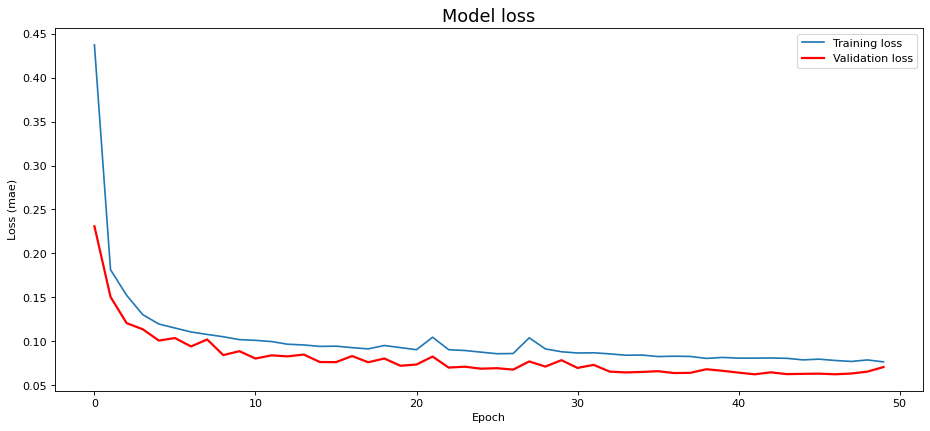

In [11]:
_, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], label='Training loss')
ax.plot(history.history['val_loss'], 'r', label='Validation loss', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [12]:
predX = model.predict(trainX)
print(predX.shape)

(174706, 14)


threshold: 13.17039096274301


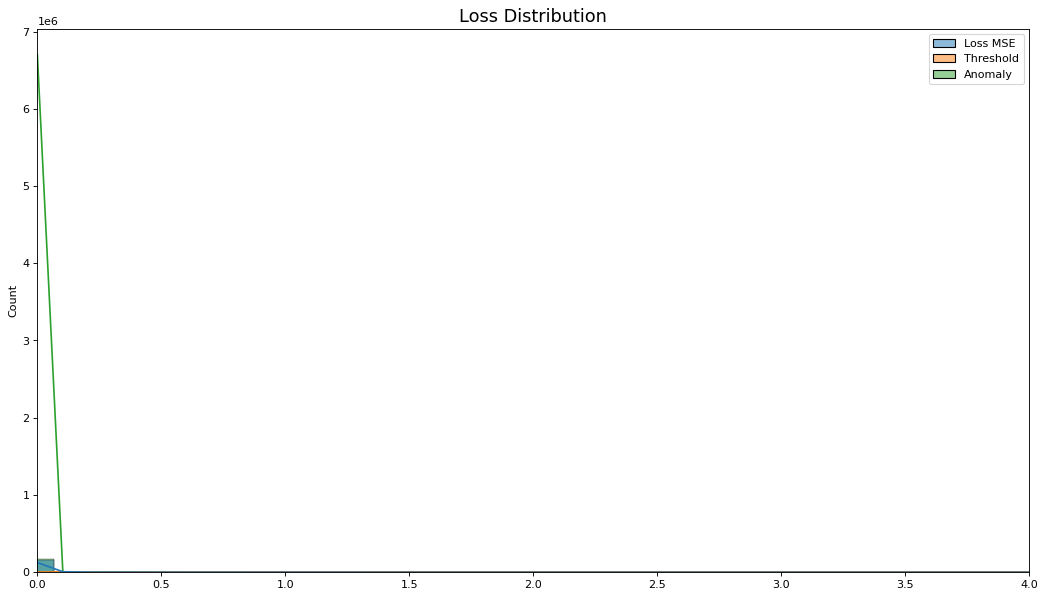

In [13]:
scored = pd.DataFrame()
scored['Loss MSE'] = np.mean(np.square(np.subtract(predX, trainY)), axis=1)
#  threshold = np.max(scored['Loss MSE'])  #  튀는 값이 있기도 해서 사용하기 않좋다.
threshold = np.percentile(scored, 99.994)  #  99.994은 4 sigma에 해당
print("threshold:", threshold)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss MSE'] > scored['Threshold']
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(data=scored, bins=300, kde=True)
plt.xlim([0.0, 4])
plt.show()

96056 103663 118359 118360 118361 127553 127554 147768 156075 156076 156077 
The number of anomaly in train set is 11


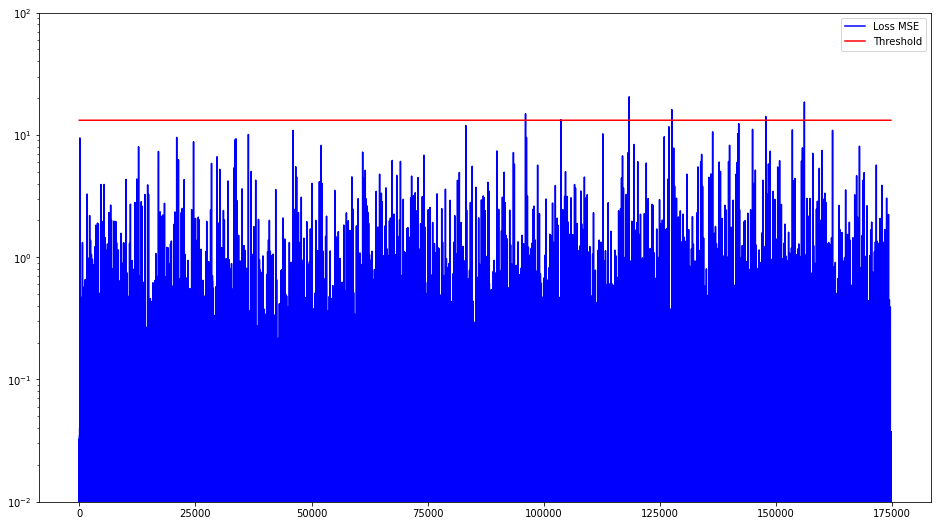

In [14]:
scored.plot(logy=True, figsize=(16,9), ylim=[1e-2, 1e2], color=['blue', 'red', 'green', 'brown'])
count = 0
for i in range(len(scored)):
    if scored['Anomaly'][i]:
        count+=1
        print(i, end=' ')        
print()
print("The number of anomaly in train set is", count)

(45000, 14)
(45000, 4)


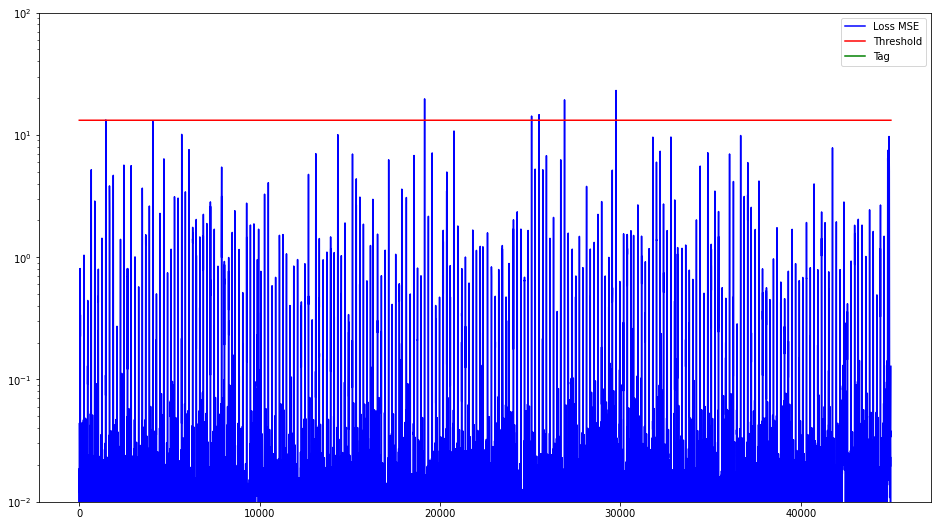

In [15]:
predX = model.predict(testX)
predX = pd.DataFrame(predX)
print(predX.shape)
scored = pd.DataFrame(index=predX.index)
scored['Loss MSE'] = np.mean(np.square(np.subtract(predX, testY)), axis=1)
scored['Threshold'] = threshold
scored['Anomaly'] = scored['Loss MSE'] > scored['Threshold']
scored['Tag'] = data.match[train_size : len(data)-ts-1] # anomaly tag
print(scored.shape)
scored.plot(logy=True, figsize=(16,9), ylim=[1e-2, 1e2], color=['blue', 'red', 'green', 'brown'])

In [16]:
for i in range(len(scored)):
    if scored['Anomaly'][i]:
        print(i, end=' ')
print()
for i in range(len(scored)):
    j = i + train_size
    if data.match[j] > 1.0:
        print(i, "(", data.match[j], ")", end=' ')
print()

1470 19144 19145 19146 25077 25078 25491 25492 26903 26904 26905 29759 29760 29761 
8278 ( 2.0 ) 8850 ( 2.0 ) 16505 ( 2.0 ) 18108 ( 2.0 ) 22604 ( 2.0 ) 24049 ( 2.0 ) 30956 ( 2.0 ) 33399 ( 2.0 ) 


수행 결과 정확도가 없다. 
즉, 두 번째 sensor값을 anomaly detection에 사용하면 제대로 동작하지 않는다는 말이다. 이후로는 첫번째 sensor 값만을 사용해서 진행해야겠다. 